In [ ]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import RCP_analysis as rcp

# ---- CONFIG ----
REPO_ROOT = Path().resolve().parents[0]
PARAMS = rcp.load_experiment_params(REPO_ROOT / "config" / "params.yaml", repo_root=REPO_ROOT)
OUT_BASE = rcp.resolve_output_root(PARAMS)
OUT_BASE.mkdir(parents=True, exist_ok=True)

ALIGNED_ROOT = OUT_BASE / "checkpoints" / "Aligned"

files = sorted(ALIGNED_ROOT.glob("aligned__*.npz"))

delay = 70
# correct for s[tim_ms_abs stim_ms_abs+100] and [stim_ms_abs + delay stim_ms_abs + delay+100]

def mask_stim_periods_and_shift(NPRW_rate, NPRW_t, UA_rate, UA_t, stim_ms_abs, delay_ms, stim_length):
    """
    Mask [stim, stim+stim_length] and [stim+delay, stim+delay+stim_length] on each array
    using its own timebase, then return NPRW(t) aligned with UA(t+delay).
    """
    stim_ms_abs = np.atleast_1d(stim_ms_abs).astype(float)

    def _mask_on_time(rate, t):
        rate = rate.copy()
        tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
        for s in stim_ms_abs:
            for t0, t1 in ((s, s + stim_length), (s + delay_ms, s + delay_ms + stim_length)):
                t0c, t1c = max(t0, tmin), min(t1, tmax)
                if t1c > t0c:
                    idx = (t >= t0c) & (t <= t1c)
                    rate[:, idx] = np.nan
        return rate

    NPRW_rate_masked = _mask_on_time(NPRW_rate, NPRW_t)
    UA_rate_masked   = _mask_on_time(UA_rate,   UA_t)

    dt_n = float(np.nanmean(np.diff(NPRW_t)))
    dt_u = float(np.nanmean(np.diff(UA_t)))
    if not (np.isfinite(dt_n) and np.isfinite(dt_u)) or dt_n <= 0 or dt_u <= 0:
        raise ValueError("Time vectors must be finite and increasing.")
    if abs(dt_n - dt_u) > 1e-6 * max(dt_n, dt_u):
        raise ValueError(f"Sampling intervals differ (NPRW {dt_n:.6f} ms vs UA {dt_u:.6f} ms). Resample first.")

    k = int(np.round(delay_ms / dt_n))  # samples

    if k >= 0:
        # Compare NPRW(t) with UA(t+delay)
        T_eff = min(NPRW_rate_masked.shape[1], UA_rate_masked.shape[1] - k)
        if T_eff <= 0:
            raise ValueError("Delay too large for overlap.")
        NPRW_t_masked     = NPRW_t[:T_eff]
        NPRW_rate_masked  = NPRW_rate_masked[:, :T_eff]
        UA_slice_t        = UA_t[k:k+T_eff]
        UA_rate_masked    = UA_rate_masked[:, k:k+T_eff]
        UA_t_masked       = UA_slice_t - delay_ms
    else:
        # Negative delay: shift NPRW forward by |k|, keep UA early segment
        k = -k
        T_eff = min(NPRW_rate_masked.shape[1] - k, UA_rate_masked.shape[1])
        if T_eff <= 0:
            raise ValueError("Delay too large for overlap.")
        NPRW_t_masked     = NPRW_t[k:k+T_eff]
        NPRW_rate_masked  = NPRW_rate_masked[:, k:k+T_eff]
        UA_slice_t        = UA_t[:T_eff]
        UA_rate_masked    = UA_rate_masked[:, :T_eff]
        UA_t_masked       = UA_slice_t - delay_ms

    return NPRW_rate_masked, UA_rate_masked, NPRW_t_masked, UA_t_masked

# ---- collectors for concatenation (NumPy) ----
nprw_chunks_np = []
ua_chunks_np   = []
tN_chunks_np   = []
tU_chunks_np   = []

for file in files:
        try:
            # NPRW_t and UA_t are the same
            NPRW_rate, NPRW_t, UA_rate, UA_t, stim_ms_abs, meta = rcp.load_combined_npz(file)
            
            # # Try to get per-row UA electrode IDs (1..256), + NSP mapping (1..128/256)
            # ua_ids_1based = None

            # with np.load(file, allow_pickle=True) as z:
            #     if "ua_row_to_elec" in z.files:
            #         ua_ids_1based = np.asarray(z["ua_row_to_elec"], dtype=int).ravel()
            #     else:
            #         # legacy fallbacks just in case
            #         for key in ("ua_ids_1based", "ua_elec_per_row", "ua_electrodes", "ua_chan_ids_1based"):
            #             if key in z.files:
            #                 ua_ids_1based = np.asarray(z[key], dtype=int).ravel()
            #                 break
            # # sanity: ensure length matches UA rows (plot uses row order)
            # if ua_ids_1based is not None and ua_ids_1based.size != UA_rate.shape[0]:
            #     print(f"[warn] ua_row_to_elec len={ua_ids_1based.size} != UA rows={UA_rate.shape[0]} — ignoring")
            #     ua_ids_1based = None
            
            sess = meta.get("session", file.stem)

            # stim times aligned to Intan aligned timebase
            stim_ms = rcp.aligned_stim_ms(stim_ms_abs, meta)
            stim_length = 100

            NPRW_rate_masked, UA_rate_masked, NPRW_t_masked, UA_t_masked = \
                mask_stim_periods_and_shift(NPRW_rate, NPRW_t, UA_rate, UA_t, stim_ms, delay, stim_length)

            # append as NumPy float32
            nprw_chunks_np.append(np.asarray(NPRW_rate_masked, dtype=np.float32))
            ua_chunks_np.append(np.asarray(UA_rate_masked,   dtype=np.float32))
            tN_chunks_np.append(np.asarray(NPRW_t_masked,    dtype=np.float32))
            tU_chunks_np.append(np.asarray(UA_t_masked,      dtype=np.float32))
            
            
        except Exception as e:
            print(f"[error] Failed on {file.name}: {e}")
            continue


# ---- finalize: concatenate on CPU (NumPy), then convert/move once ----
if not nprw_chunks_np:
    raise RuntimeError("No aligned files were loaded successfully.")

# concat time axis
NPRW_np = np.concatenate(nprw_chunks_np, axis=1)   # (C_nprw, T_total)
UA_np   = np.concatenate(ua_chunks_np,   axis=1)   # (C_ua,   T_total)
NPRW_time = np.concatenate(tN_chunks_np, axis=0)   # (T_total,)
UA_time   = np.concatenate(tU_chunks_np, axis=0)   # (T_total,)

# convert to torch
# Build a time mask on CPU (True = no NaNs in either stream at that time)
device = torch.device("cuda")
valid_t = np.isfinite(NPRW_np).all(axis=0) & np.isfinite(UA_np).all(axis=0)

# build (N_valid, C) tensors on device
NPRW_tensor = torch.as_tensor(np.nan_to_num(NPRW_np[:, valid_t], nan=0.0).T, device=device, dtype=torch.float32)
UA_tensor   = torch.as_tensor(np.nan_to_num(UA_np[:,  valid_t], nan=0.0).T, device=device, dtype=torch.float32)

print(f"Device: {device}")
print(f"NPRW_tensor: {tuple(NPRW_tensor.shape)}, UA_tensor: {tuple(UA_tensor.shape)}")
print(f"NPRW_time: {NPRW_time.shape}, UA_time: {UA_time.shape}")

TypeError: 'PosixPath' object is not iterable

Encode NPRW firing rate
Decode, to get xhat, which is the estimation of firing rate in UA,

Try different values for rank r - and find elbow

In [ ]:
class rrr(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(rrr, self).__init__()      
        self.encoder = nn.Linear(input_dim, rank)
        self.decoder = nn.Linear(rank, output_dim)

    def forward(self, xtrain):
        rrr_rep = self.encoder(xtrain)
        output_hat = self.decoder(rrr_rep)
        return output_hat

Convert firing rate into pytorch tensor, remove artifact segments

In [76]:
torch.var(UA_tensor, dim=0).mean()

tensor(105295.9531, device='cuda:0')

rank= 1  final MSE=100110.289062
rank= 3  final MSE=98258.593750
rank= 5  final MSE=97634.757812
rank= 7  final MSE=97233.343750
rank= 9  final MSE=96958.812500
rank=11  final MSE=96967.687500
rank=13  final MSE=96671.382812
rank=15  final MSE=96618.656250
rank=17  final MSE=96566.453125
rank=19  final MSE=96537.242188


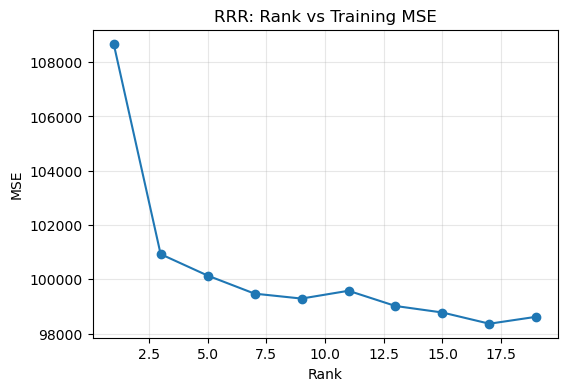

In [74]:
import matplotlib.pyplot as plt
ranks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19] # to 20

input_dim = 128 # channels of NPRW
output_dim = 128 # channels of UA interested

rank_to_mse = {}
for rank in ranks:
    model = rrr(input_dim, output_dim, rank).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    num_epochs = 500
    for epoch in range(num_epochs):
        optimizer.zero_grad(set_to_none=True)
        outputs = model(NPRW_tensor)
        loss = criterion(outputs, UA_tensor)
        loss.backward()
        optimizer.step()
        if epoch == 99:
            rank_to_mse[rank] = loss.item()
    print(f"rank={rank:2d}  final MSE={loss:.6f}")

# Plot rank vs MSE
rs = sorted(rank_to_mse.keys())
mses = [rank_to_mse[r] for r in rs]

plt.figure(figsize=(6,4))
plt.plot(rs, mses, marker='o')
plt.xlabel("Rank")
plt.ylabel("MSE")
plt.title("RRR: Rank vs Training MSE")
plt.grid(True, alpha=0.3)
plt.show()
